# *"Real or NOT"*  NLP to Identify Public Emergency Related Tweets


## Introduction

Being able to predict which Tweets are about real Public Emergencies (*eg Earthquakes, Floods, Terrorist Events*) and which ones are not. 

(The words 'Pubic Emergency' and 'Disasters' have been used interchangeably)

> Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

> But, it’s not always clear whether a person’s words are actually announcing a disaster. 

*Source: [Real or Not? NLP with Disaster Tweets, A Kaggle Competition](https://www.kaggle.com/c/nlp-getting-started/overview)*

### Goal

**High-Level Objective**
Demonstrate that a series of relatively weak/simpler learning algorithms can be combined to get a much more 'powerful' algorithm. 

**Nuances**

The goal of this specific notebook is to get the best possible model using un-tuned 'classical' machine learning algorithms and ensemble methods.

*Notes*
* **'Classical' Models** Using all machine learning techniques other than Neural Networks and Deep Learning frameworks. The 'classical moniker may be a bit misleading but I imply it to cover techniques from Logistic Regression, to Support Vector Machines and Random Forests
* **Untuned Models** The default versions of the algorithms (without any hyper-parameter tuning)
* **Ensemble Methods** The individual models have been combined together using a [Voting Classifier](https://www.geeksforgeeks.org/ml-voting-classifier-using-sklearn/)



### Result Summary

This ensemble-based approach yields an out of sample accuracy of 80% which is ***awesome*** considering that I am using un-tuned versions of the more 'classical' algorithms. 

This result speaks to the power of combining a set of weak predictors to get a much better result (which is the purpose of ensemble techniques)

### Table of Contents
1. Getting Data
2. Exploring Data *(and creating derived variables)* 
3. Text Preprocessing *(Standard and Improvised NLP techniques)* 
4. Bag of Words *(text vectorization)*
5. Analytical Dataset *(Training and Validation purposes)*
6. A Set of Initial Models *(A set of weak learners)*
7. Building out the Ensemble
8. Practical Examples







***
<br>

**List of References:**

I ended learning a lot from the below-mentioned sources, which include technical papers, blogs, Kaggle Kernels and Github repositories.

1. [Phonetic-Based Microtext Normalization for Twitter Sentiment Analysis, 2017 IEEE International Conference on Data Mining Workshops](https://sentic.net/microtext-normalization.pdf)
2. [Building Beautiful NLP Applications, A Blog by Kavita Ganesan](https://kavita-ganesan.com/)
3. [Using Apply and Lambda Functions](https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7)
3. [Creating wordcloud visualizations, Kaggle](https://www.kaggle.com/aashita/word-clouds-of-various-shapes)
4. [Text Preprocessing Note, GitHub](https://github.com/kavgan/nlp-in-practice/blob/master/text-pre-processing/Text%20Preprocessing%20Examples.ipynb)
5. [Exploring Nested Predictors (Emsemble) for NLP, Kaggle](https://www.kaggle.com/doomdiskday/full-tutoria-eda-to-ensembles-embeddings-zoo)


***


## 1. Getting Data

In [1]:
# Initial Housekeeping

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "RealorNot_NLP"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

#create the reqired folders if they don't already exist
os.makedirs(IMAGES_PATH, exist_ok=True)

# A simple function that helps save images
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


# Filter out unnecessary warnings
import warnings 
warnings.filterwarnings('ignore')

In [114]:
# Housekeeping, Part 2 (Time Series Standard)

# to make the plots larger in size
from pylab import rcParams
rcParams['figure.figsize'] = 16,10
rcParams['figure.titlesize'] = 14


# A set of libraries pertaining to forecasting methods

# from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import month_plot, quarter_plot
# from statsmodels.tsa.statespace.tools import diff
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from pmdarima import auto_arima
# from statsmodels.tsa.filters.hp_filter import hpfilter

from sklearn.metrics import mean_squared_error

In [171]:
# Housekeeping, Part 3. Scikit-Learn Related

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


#defining a neat function to calculate model accuracy KPIs

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def model_performance_scores(train,predicted):
    precision_kpi = precision_score(train,predicted)
    recall_kpi = recall_score(train, predicted)
    f1_kpi = f1_score(train,predicted)
    accuracy_kpi = accuracy_score(train, predicted)
    total_positive_class = np.sum(np.array(train) == True, axis=0)
    total_instances = len(train)
    per_positive_class = total_positive_class/ total_instances
    per_negative_class = 1 - per_positive_class
    
    print("model performance scores: ")
    
    print("% instances of the positive class", per_positive_class)
    print("% instances of the negative class", per_negative_class)
    print("model prediction accuracy", accuracy_kpi )
    
    print("Precision = ", precision_kpi)
    print("Recall = ", recall_kpi)
    print("F1 = ", f1_kpi)    
    
    print("\n")


In [123]:
# Housekeeping, Part 4. NLP Specific Packages


# A custom function for creating wordclouds

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


def plot_wordcloud(text, max_words=400, 
                   min_font_size= 4 ,max_font_size=120,
                   min_word_lengthint = None,
                   figure_size=(24.0,16.0), 
                   title = None, title_size=40, 
                   mask = None):
    
    stopwords = set(STOPWORDS)
    
    #more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    #stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    width = 1200,
                    height = 800,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    min_font_size = min_font_size,
                    random_state = 42,
                    mask = None)
    
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    


In [208]:
# Housekeeping, Part 5. NLP Specific Packages

import nltk
from nltk.stem import PorterStemmer

Note: *[documentation on the wordcloud API](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud)*

In [5]:
# Getting the data

df = pd.read_csv('/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/Real_Not_NLP/train.csv')
test = pd.read_csv('/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/Real_Not_NLP/test.csv')


Having a quick look at the data

In [6]:
print("Shape of the provided dataset", df.shape)
print("Shape of the test dataset", test.shape)

Shape of the provided dataset (7613, 5)
Shape of the test dataset (3263, 4)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df[10:20]

,id,keyword,location,text,target
10,16,NaN,NaN,Three people died from the heat wave so far,1
11,17,NaN,NaN,Haha South Tampa is getting flooded hah- WAIT ...,1
12,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1
13,19,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1
14,20,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


In [10]:
df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

Saving figure  A starter wordcloud


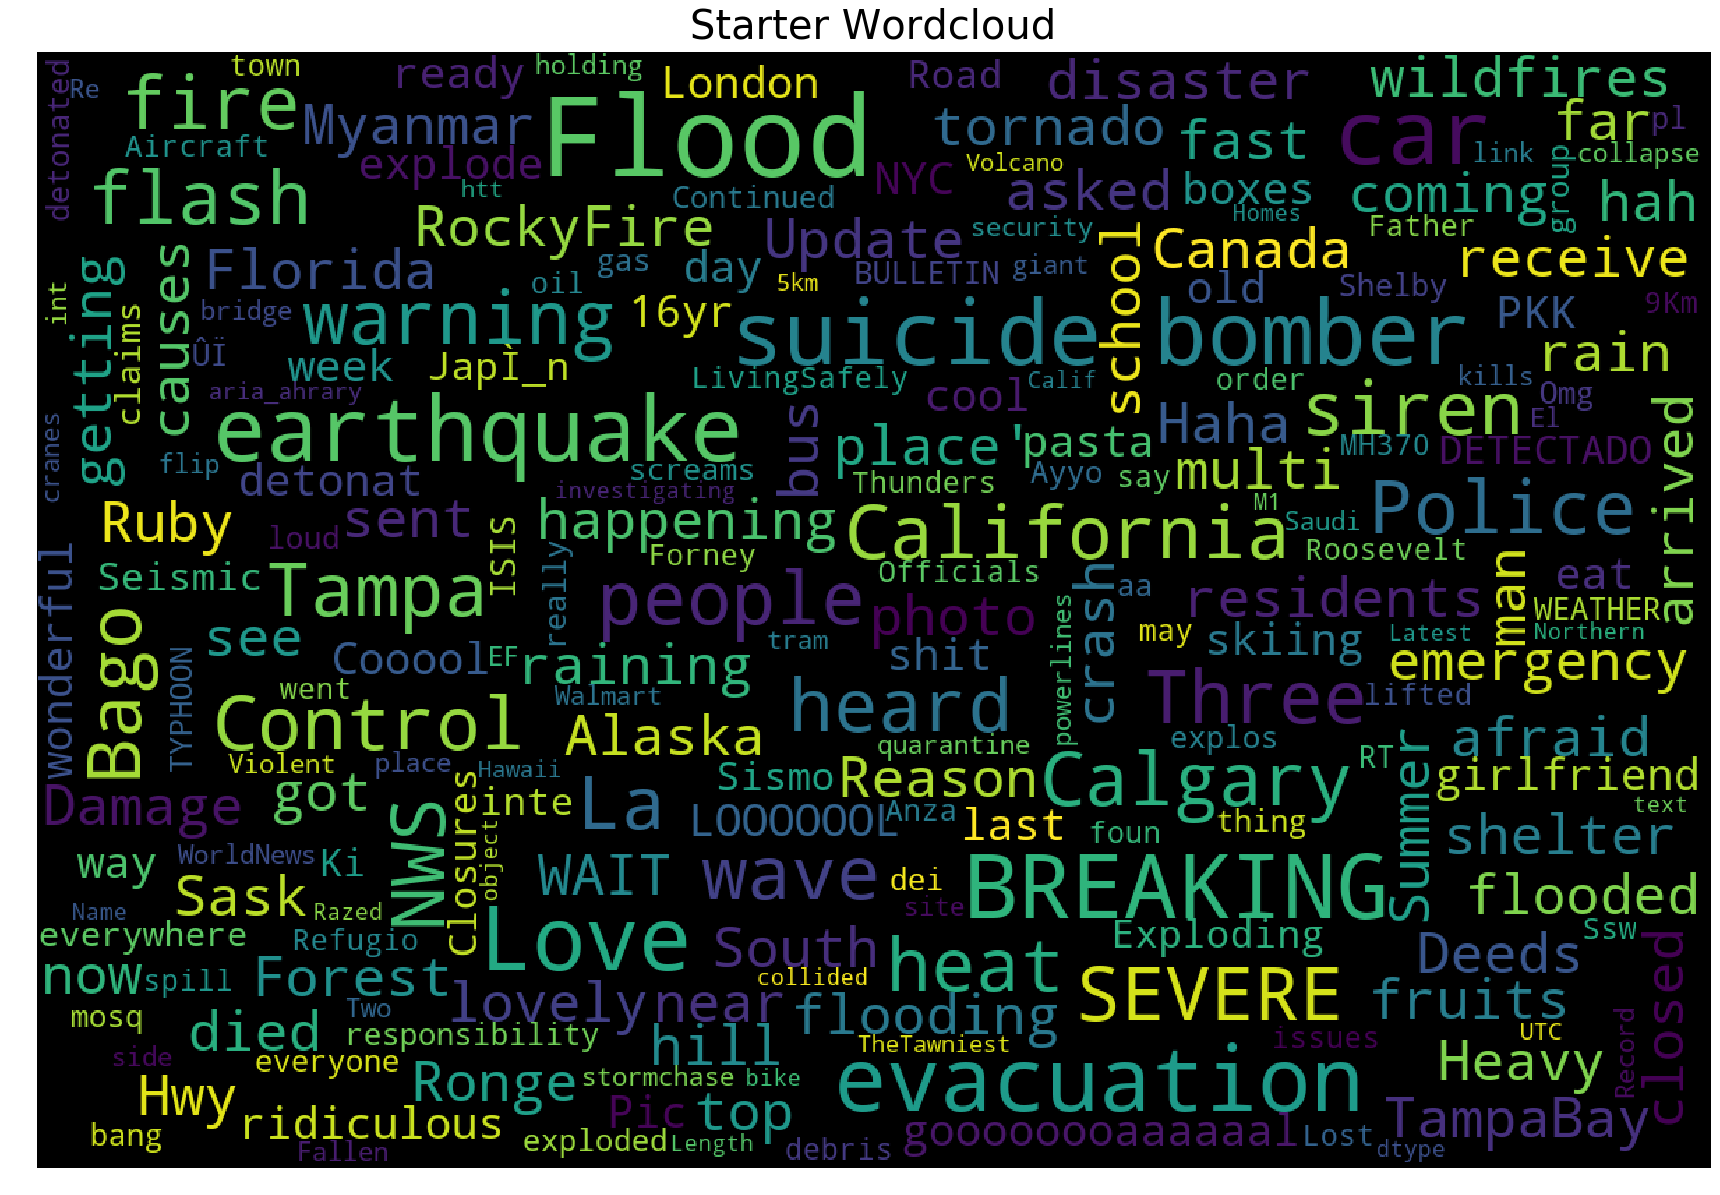

In [124]:
# A General Wordcloud for all the data

tweet_text = str(df.text)

plot_wordcloud(tweet_text, max_words=400, max_font_size=80, 
               figure_size=(24,24),
               title = "Starter Wordcloud", title_size=40)

save_fig(" A starter wordcloud", tight_layout = False)

***

## 2. Exploring Data

In this section, we will explore the data and prepare the analytical data-set.

Subtasks ( **Data Exploration** ):
1. Checking for missing values 
2. Understanding distribution of target variable
3. Deepdive into the `location` and `keyword` variable

Subtasks ( **Creating New Variables** ):
1. Creating a `text_len` variable signifying the length of tweet
2. Creating `kw_avl` and `loc_avl` variables



### 2.1 Exploring Data

#### Split of 'target' class

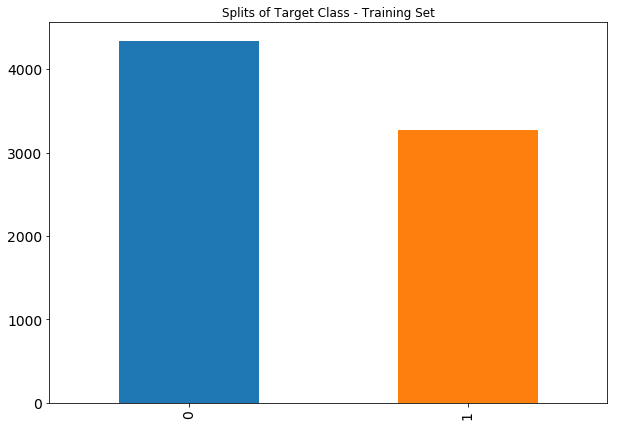

In [107]:
df['target'].value_counts().plot.bar(title = "Splits of Target Class - Training Set", fontsize = 14, figsize = (10,7))

#### Addressing Null Values

In [35]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [36]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Let us set the `NA` values to `None`**
Since all the NA related fields are text columns, this looks to be the best approach.

In [37]:
df = df.fillna('None')

In [38]:
test = test.fillna('None')

In [39]:
# checking the training data for NA

df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

#### WordCloud for the Tweets 

Saving figure  Wordcloud for Disaster Tweets


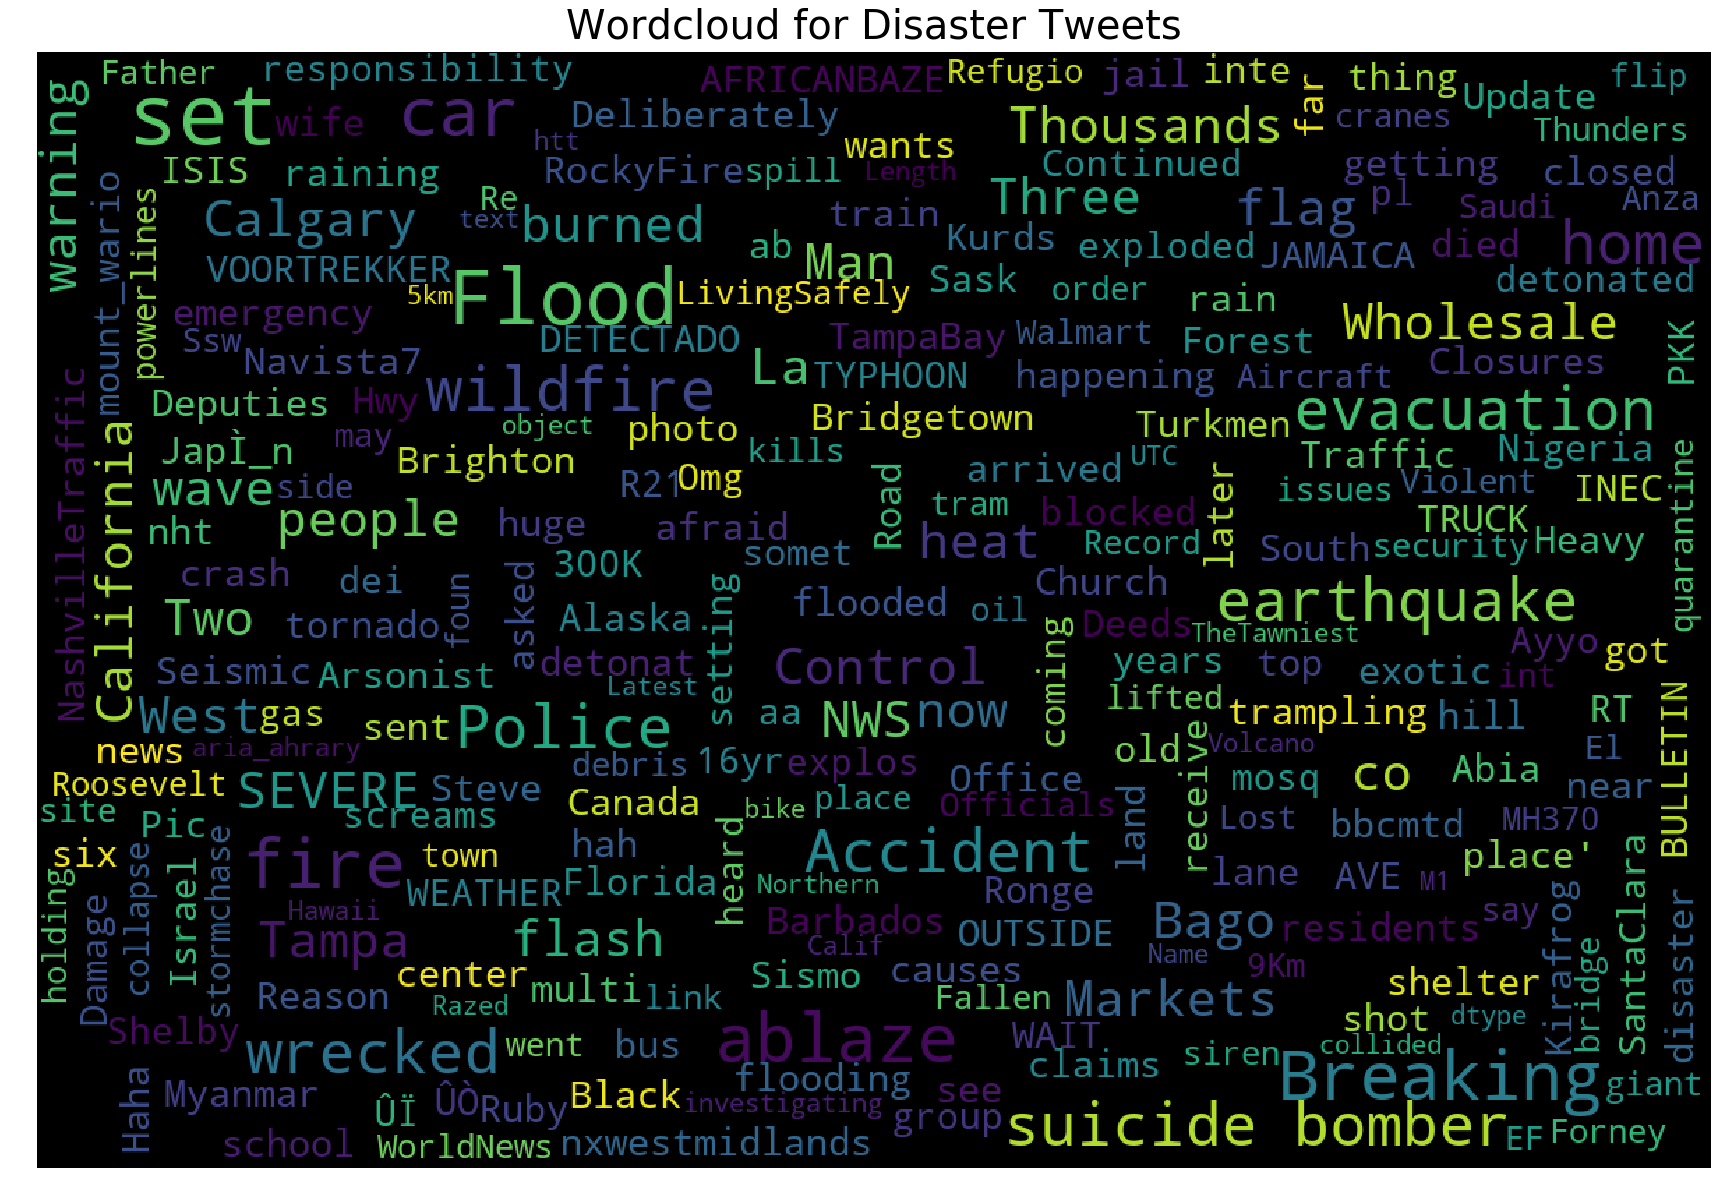

In [125]:
# WordCloud for the Tweets that are disaster related

subset = df[df['target']==1]

tweet_text1 = str(subset.text)

plot_wordcloud(tweet_text1, max_words=400, max_font_size=60, 
               figure_size=(24,24),min_font_size = 8,
               title = "Wordcloud for Disaster Tweets", title_size=40)

save_fig(" Wordcloud for Disaster Tweets", tight_layout = False)

Saving figure  Wordcloud Tweets that aren't Disaster Related


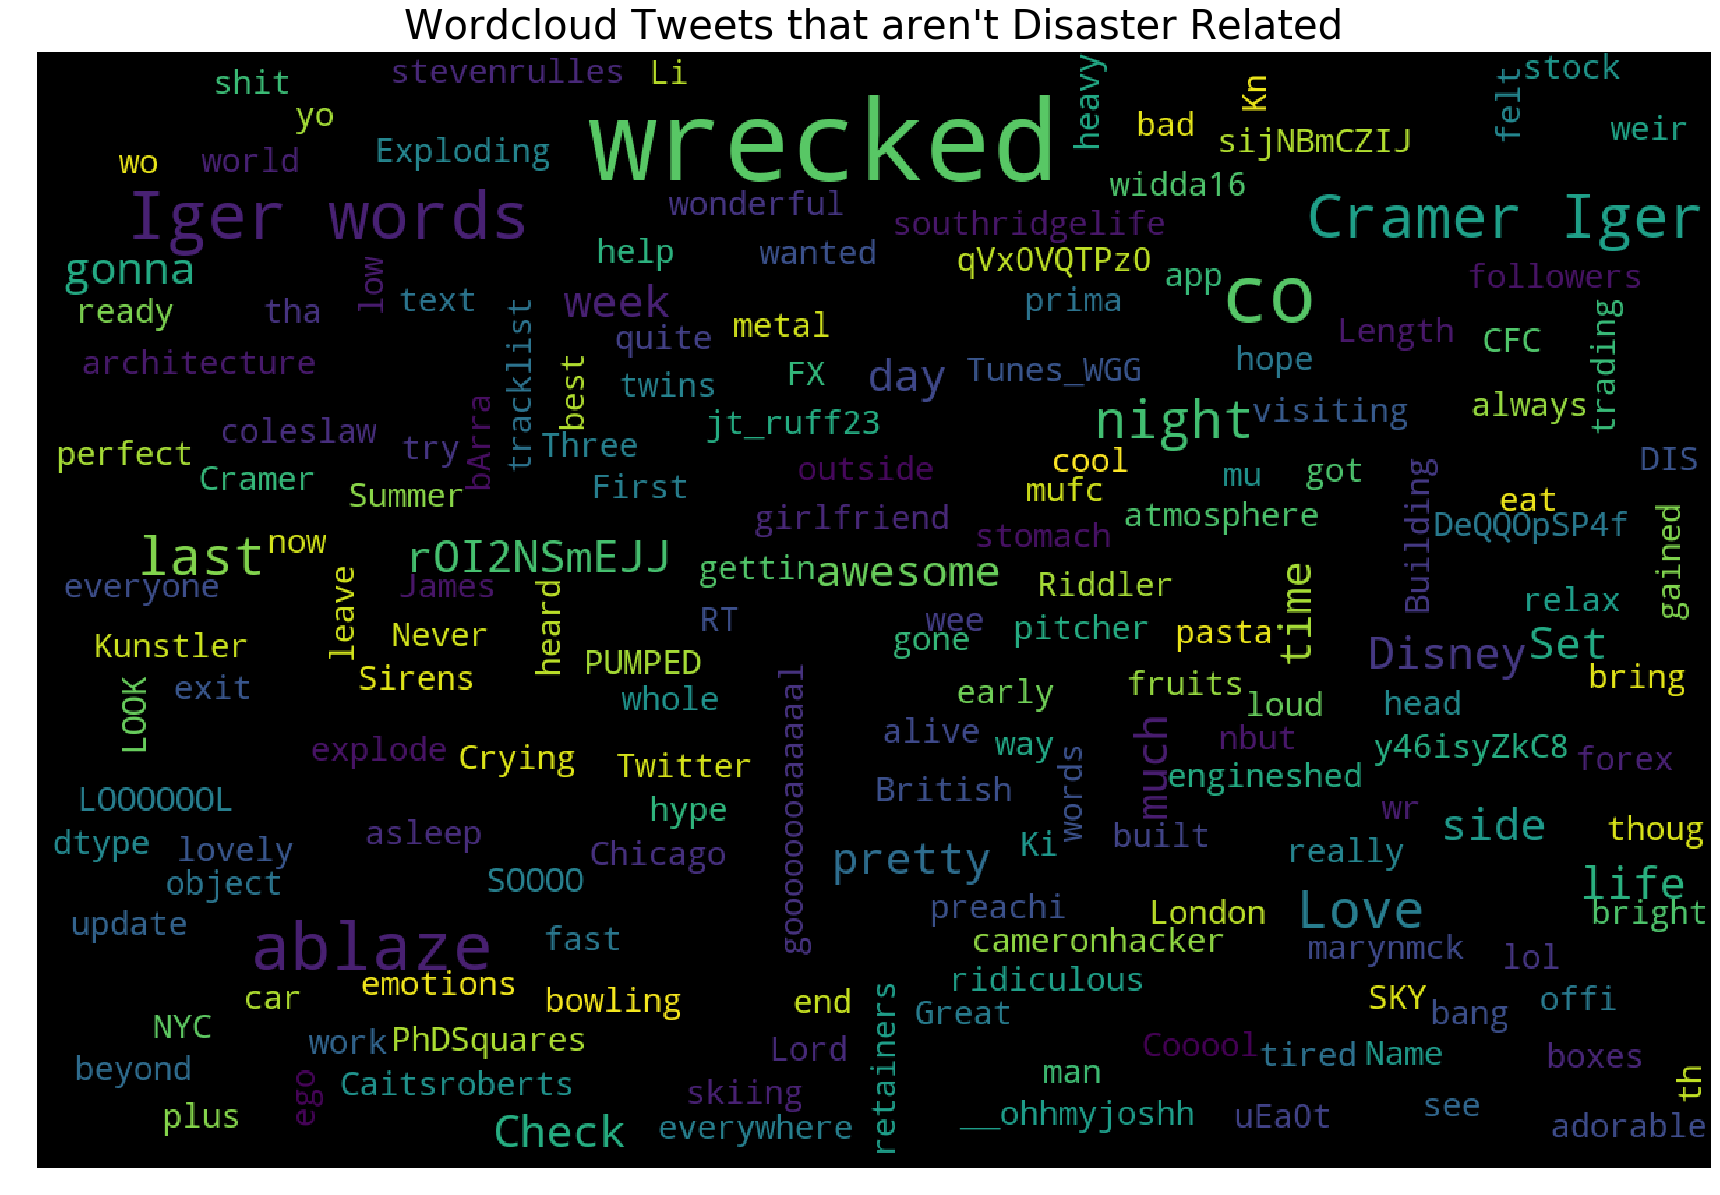

In [126]:
# WordCloud for the Tweets that are NOT disaster related

subset1 = df[df['target']==0]

tweet_text2 = str(subset1.text)

plot_wordcloud(tweet_text2, max_words=300, max_font_size=80, 
               figure_size=(24,24),min_font_size = 12,
               title = "Wordcloud Tweets that aren't Disaster Related", title_size=40)

save_fig(" Wordcloud Tweets that aren't Disaster Related", tight_layout = False)

In [86]:
temp = df[df['target'] == 1]

temp.shape

(3271, 5)

#### Top Location and Keywords

Saving figure Locations for the Tweets


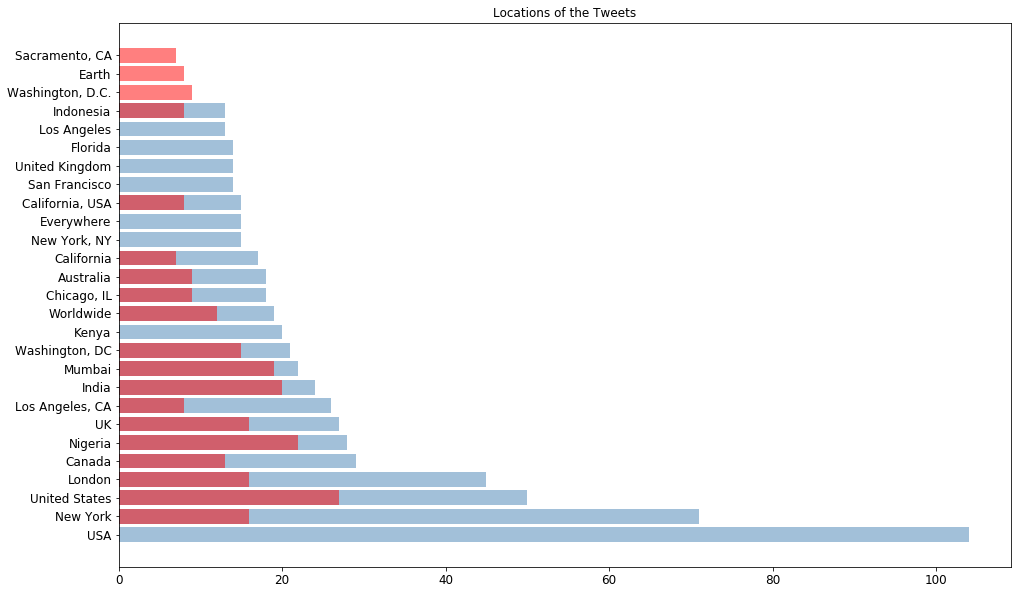

In [116]:
# Which are the top 20 locations

loc_ = df['location'].value_counts()
loc_.reset_index() # VERY Important
loc_ = loc_[1:25] #Just the fist 20

loc_d = temp['location'].value_counts()[1:21]
loc_d.reset_index() # VERY Important
loc_d = loc_d[1:25] #Just the fist 20


# Plotting it out

plt.figure(figsize = (16,10))

plt.title('Locations of the Tweets')

plt.barh(y = loc_.index, width = loc_.values, alpha = 0.5, color = 'steelblue' )
plt.barh(y = loc_d.index, width = loc_d.values, alpha = 0.5, color = 'red')


save_fig('Locations for the Tweets', tight_layout = False)

Saving figure Keywords Tagged with the Tweets


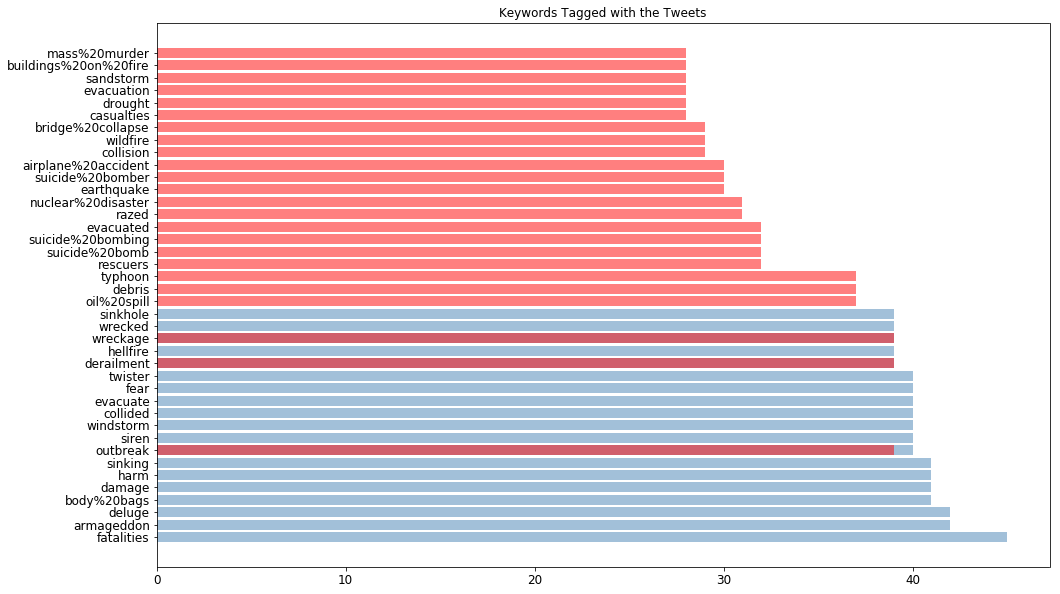

In [97]:
# Which are the top 20 locations

loc_ = df['keyword'].value_counts()
loc_.reset_index() # VERY Important
loc_ = loc_[1:20]

loc_d = temp['keyword'].value_counts()
loc_d.reset_index() # VERY Important
loc_d = loc_d[1:25]



# Plotting it out

plt.figure(figsize = (16,10))

plt.title('Keywords Tagged with the Tweets')
plt.barh(y = loc_.index, width = loc_.values, alpha = 0.5, color = 'steelblue' )
plt.barh(y = loc_d.index, width = loc_d.values, alpha = 0.5, color = 'red')


save_fig('Keywords Tagged with the Tweets', tight_layout = False)

**Observations:**
1. Both `keyword` and `location` variables look to be meaningful
2. The `keyword` field looks particularly interesting as the tweets pertaining to disasters seem to have a different set of keywords when compared to the ones that dont

### 2.2 Derived Variables

#### 1. `text_len`
Create `text_len` variable corresponding to the chacater length of the Tweet

In [127]:
df['text_len'] = df['text'].str.len()
test['text_len'] = test['text'].str.len()


df.head()

# Simple thing, but took me a while to accomplish

,id,keyword,location,text,target,text_len
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,38
2,5,None,None,All residents asked to 'shelter in place' are ...,1,133
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,65
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,88


Exploring the distribution of `text_len` variable

Saving figure Distribution of Tweet Length (in no of char)


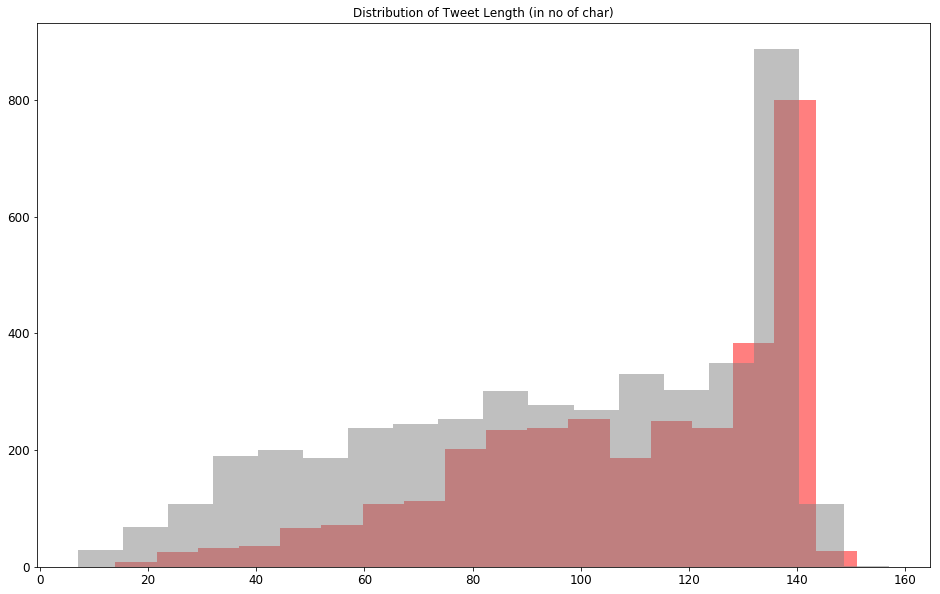

In [131]:
plt.figure(1)

plt.title('Distribution of Tweet Length (in no of char)')
plt.hist(df[df['target']==1]['text_len'], bins =18, alpha = 0.5, color = 'red',histtype='stepfilled')
plt.hist(df[df['target']==0]['text_len'], bins =18, alpha = 0.5, color = 'grey',histtype='stepfilled')

save_fig('Distribution of Tweet Length (in no of char)', tight_layout = False)

Disaster Tweets seem to be **longer**

## 3. Text Preprocesssing

Techniques such as 
1. Converting **text to lowercase**
2. **Removing Noise** (Punctuation, Special Character, Numbers, HTML formattings etc.)
3. *not in the first pass* **Normalization** (especially important for microtext formats like SMS and Tweets. *e.g. 2moro, tmro -> tomorrow* )

In [132]:
df['text'][0:20]

0     Our Deeds are the Reason of this #earthquake M...
1                Forest fire near La Ronge Sask. Canada
2     All residents asked to 'shelter in place' are ...
3     13,000 people receive #wildfires evacuation or...
4     Just got sent this photo from Ruby #Alaska as ...
5     #RockyFire Update => California Hwy. 20 closed...
6     #flood #disaster Heavy rain causes flash flood...
7     I'm on top of the hill and I can see a fire in...
8     There's an emergency evacuation happening now ...
9     I'm afraid that the tornado is coming to our a...
10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
15                                       What's up man?
16                                        I love fruits
17                                     Summer is

In [133]:
import re
import string

# defining a function to convert to lowercase and to remove noise

def lcase_remNoise(text):
    
    # make lowercase
    text = text.lower()
    
    # The syntax of re.sub() is:: re.sub(pattern, replace, source_string)
    
    #rewrite this code - TBD TBD TBD
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [134]:
# Applying this cleaning function to both the test and training datasets

# training set
df['text'] = df.apply(lambda x: lcase_remNoise(x['text']),axis=1)

# test set
test['text'] = df.apply(lambda x: lcase_remNoise(x['text']),axis=1)

In [141]:
df['text'][5:11]

5     rockyfire update  california hwy  closed in bo...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
Name: text, dtype: object

In [213]:
# Experiementing with PorterStemmer

def porterf(text):
    
    from nltk.stem import PorterStemmer 
    from nltk.tokenize import word_tokenize 
   
    text_ret = ""
    ps = PorterStemmer() 
      
    words = word_tokenize(text) 
   
    for w in words: 
        text_ret = text_ret + " " + ps.stem(w)
    
    return text_ret

In [220]:
# Applying porter stemmer to both the test and training datasets

# training set
df['text'] = df.apply(lambda x: porterf(x['text']),axis=1)

# test set
test['text'] = df.apply(lambda x: porterf(x['text']),axis=1)

In [221]:
df['text'][0:20]

0      our deed are the reason of thi earthquak may ...
1                  forest fire near la rong sask canada
2      all resid ask to shelter in place are be noti...
3        peopl receiv wildfir evacu order in california
4      just got sent thi photo from rubi alaska as s...
5      rockyfir updat california hwi close in both d...
6      flood disast heavi rain caus flash flood of s...
7      im on top of the hill and i can see a fire in...
8      there an emerg evacu happen now in the build ...
9        im afraid that the tornado is come to our area
10            three peopl die from the heat wave so far
11     haha south tampa is get flood hah wait a seco...
12     rain flood florida tampabay tampa or day ive ...
13                  flood in bago myanmar we arriv bago
14       damag to school bu on in multi car crash break
15                                          what up man
16                                         i love fruit
17                                       summer 

#### `location` variable cleanup

Removed some of the noise from the `text` variable, 
Shall apply the same approach to the `location` variable.

Addtionally, will process the `location` variable so that: 
* remove spaces
* take only the first 10 characters

In [135]:
df['location'].value_counts()[5:11]

Canada             29
Nigeria            28
UK                 27
Los Angeles, CA    26
India              24
Mumbai             22
Name: location, dtype: int64

In [136]:
# training set
df['location'] = df.apply(lambda x: lcase_remNoise(x['location']),axis=1)

# test set
test['location'] = df.apply(lambda x: lcase_remNoise(x['location']),axis=1)

In [137]:
df['location'].value_counts()[5:11]

united states    50
washington dc    41
canada           33
worldwide        33
uk               32
nigeria          31
Name: location, dtype: int64

In [138]:
def remsp_strip(text):

    text = re.sub(' ', '', text)
    text = text[0:10]
    
    return text

In [139]:
# training set
df['location'] = df.apply(lambda x: remsp_strip(x['location']),axis=1)

# test set
test['location'] = df.apply(lambda x: remsp_strip(x['location']),axis=1)

In [140]:
df['location'].value_counts()[5:11]

unitedstat    53
losangeles    53
london        51
california    45
worldwide     38
canada        35
Name: location, dtype: int64

Saving figure Locations for the Tweets (post data clean-up)


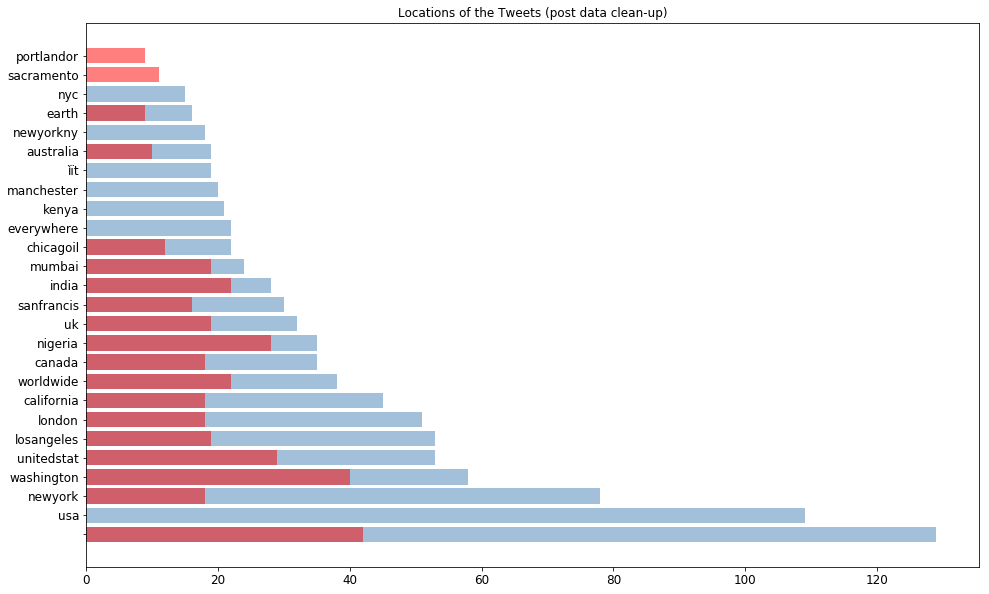

In [143]:
# Which are the top 20 locations

temp2 = df[df['target'] == 1]

temp2.shape


loc_ = df['location'].value_counts()
loc_.reset_index() # VERY Important
loc_ = loc_[1:25] #Just the fist 20

loc_d = temp2['location'].value_counts()[1:21]
loc_d.reset_index() # VERY Important
loc_d = loc_d[1:25] #Just the fist 20


# Plotting it out

plt.figure(figsize = (16,10))

plt.title('Locations of the Tweets (post data clean-up)')

plt.barh(y = loc_.index, width = loc_.values, alpha = 0.5, color = 'steelblue' )
plt.barh(y = loc_d.index, width = loc_d.values, alpha = 0.5, color = 'red')


save_fig('Locations for the Tweets (post data clean-up)', tight_layout = False)

In [207]:
df['location'].value_counts()[0:10]

none          2533
               129
usa            109
newyork         78
washington      58
unitedstat      53
losangeles      53
london          51
california      45
worldwide       38
Name: location, dtype: int64

#### `keyword` variable clean-up

Ascertaining if the clean-up is required at the first place.?

In [145]:
df['keyword'].value_counts()[1:20]

fatalities     45
armageddon     42
deluge         42
body%20bags    41
damage         41
harm           41
sinking        41
outbreak       40
siren          40
windstorm      40
collided       40
evacuate       40
fear           40
twister        40
derailment     39
hellfire       39
wreckage       39
wrecked        39
sinkhole       39
Name: keyword, dtype: int64

`keyword` variable looks fairly standardized yet, would like to implement **porter stemmer**

<br>


In [222]:
# training set
df['keyword'] = df.apply(lambda x: porterf(x['keyword']),axis=1)

# test set
test['keyword'] = df.apply(lambda x: porterf(x['keyword']),axis=1)

In [223]:
df['keyword'].value_counts()[1:20]

 derail          112
 evacu           112
 flood           109
 bodi % 20bag    107
 scream          105
 drown           104
 bomb            101
 hijack          100
 obliter          91
 weapon           78
 wreck            76
 collid           74
 death            74
 blaze            72
 explod           71
 attack           71
 quarantin        71
 injuri           71
 wound            70
Name: keyword, dtype: int64

Implementation of porter stemmer looks to have made a significant difference.

Saving figure Keywords for the Tweets (post implementing porter stemmer)


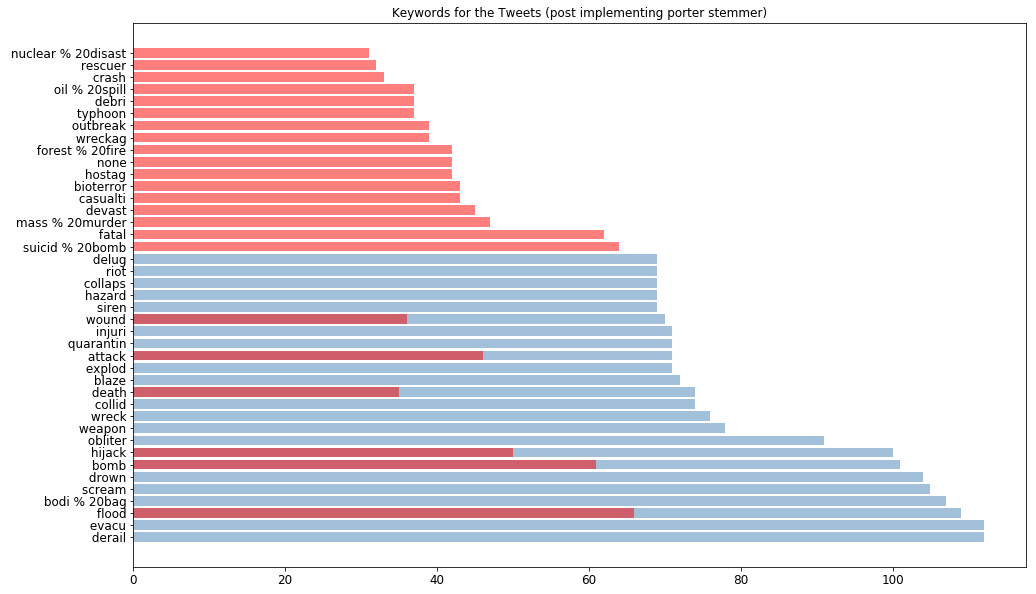

In [225]:
# Which are the top 25 keywords

temp3 = df[df['target'] == 1]

temp3.shape


loc_ = df['keyword'].value_counts()
loc_.reset_index() # VERY Important
loc_ = loc_[1:25] #Just the fist 20

loc_d = temp3['keyword'].value_counts()[1:25]
loc_d.reset_index() # VERY Important
loc_d = loc_d[1:25] #Just the fist 20


# Plotting it out

plt.figure(figsize = (16,10))

plt.title('Keywords for the Tweets (post implementing porter stemmer)')

plt.barh(y = loc_.index, width = loc_.values, alpha = 0.5, color = 'steelblue' )
plt.barh(y = loc_d.index, width = loc_d.values, alpha = 0.5, color = 'red')


save_fig('Keywords for the Tweets (post implementing porter stemmer)', tight_layout = False)

## 4. Bag of Words using `TfidfVectorizer`


In [226]:
X = df[['keyword','location','text','text_len']]
y = df[['target']]

X.head()

,keyword,location,text,text_len
0,none,none,our deed are the reason of thi earthquak may ...,69
1,none,none,forest fire near la rong sask canada,38
2,none,none,all resid ask to shelter in place are be noti...,133
3,none,none,peopl receiv wildfir evacu order in california,65
4,none,none,just got sent thi photo from rubi alaska as s...,88


In [227]:
X_test = test[['keyword','location','text','text_len']]
X_test.head()

,keyword,location,text,text_len
0,none,none,our deed are the reason of thi earthquak may ...,34
1,none,none,forest fire near la rong sask canada,64
2,none,none,all resid ask to shelter in place are be noti...,96
3,none,none,peopl receiv wildfir evacu order in california,40
4,none,none,just got sent thi photo from rubi alaska as s...,45


In [ ]:
#X_s = X['text'].tolist() # VERY, VERY IMPORTANT

In [228]:
tfidf_txt = TfidfVectorizer()

X_txt = tfidf_txt.fit_transform(X['text'])

In [229]:
print (X_txt.shape)
print (type(X_txt))

(7613, 13564)
<class 'scipy.sparse.csr.csr_matrix'>


In [230]:
X_test_txt = tfidf_txt.transform(X_test['text'])

In [231]:
X_test_txt.shape

(3263, 13564)

So, the **important** thing to note is:
***when you use fit_tranform and transform respectively, you get equivalent vectors***


In [232]:
X_txt = X_txt.toarray()

print(type(X_txt))

<class 'numpy.ndarray'>


In [233]:
X_test_txt = X_test_txt.toarray()

In [234]:
print("X_txt shape", X_txt.shape)
print("X_test_txt shape", X_test_txt.shape)

X_txt shape (7613, 13564)
X_test_txt shape (3263, 13564)


#### Encoding `keyword` and `location`

For *one next to the other concatenation*, we use `np.concatenate((df1,df2),1)`

Shall use `OneHotEncoder`to encode these fields

In [235]:
X.head()

,keyword,location,text,text_len
0,none,none,our deed are the reason of thi earthquak may ...,69
1,none,none,forest fire near la rong sask canada,38
2,none,none,all resid ask to shelter in place are be noti...,133
3,none,none,peopl receiv wildfir evacu order in california,65
4,none,none,just got sent thi photo from rubi alaska as s...,88


In [160]:
ohe_location = OneHotEncoder(sparse = False)

X_loc = ohe_location.fit_transform(X[['location']])

X_loc.shape

(7613, 2721)

In [161]:
X_test_loc = ohe_location.transform(X_test[['location']])

X_test_loc.shape

(3263, 2721)

In [238]:
ohe_key = OneHotEncoder(sparse = False, handle_unknown='ignore')

X_key = ohe_key.fit_transform(X[['keyword']])

X_key.shape

(7613, 167)

In [239]:
X_test_key = ohe_key.transform(X_test[['keyword']])

X_test_key.shape

(3263, 167)

In [164]:
X_len = X[['text_len']]

X_len.shape

(7613, 1)

In [165]:
X_test_len = X_test[['text_len']]

X_test_len.shape

(3263, 1)

**To sum up**

I am in this unique situation where I have 4 training data-sets:
1. `X_txt` comprising tweets converted to a *inverse frequency - document term matrix*
2. `X_loc`, an encoded version of the `location` field
3. `X_key` an encoded version of the `keyword` field
4. `X_len` corresponding to the length of the tweets

All the above transformations have been performed **`test`** dataset as well.

## 5. Analytical Dataset

Now, the next step is to divide the data into **training and validation sets**


In [240]:
from sklearn.model_selection import train_test_split

X_txt_train, X_txt_val,X_loc_train, X_loc_val,X_key_train, X_key_val,X_len_train, X_len_val, y_train, y_val = train_test_split(X_txt, X_loc, X_key, X_len, y, test_size=0.20, random_state= 42)

In [241]:
print("size of training sets", X_txt_train.shape, X_loc_train.shape,X_key_train.shape,X_len_train.shape)


print("size of validation set", X_txt_val.shape, X_loc_val.shape,X_key_val.shape,X_len_val.shape)

size of training sets (6090, 13564) (6090, 2721) (6090, 167) (6090, 1)
size of validation set (1523, 13564) (1523, 2721) (1523, 167) (1523, 1)


In [242]:
# scaling the data

from sklearn.preprocessing import StandardScaler

stdsca_txt = StandardScaler()
stdsca_loc = StandardScaler()
stdsca_key = StandardScaler()
stdsca_len = StandardScaler()


X_txt_train = stdsca_txt.fit_transform(X_txt_train)
X_txt_val = stdsca_txt.transform(X_txt_val)
X_txt_test = stdsca_txt.transform(X_test_txt)

X_loc_train = stdsca_loc.fit_transform(X_loc_train)
X_loc_val = stdsca_loc.transform(X_loc_val)
X_loc_test = stdsca_loc.transform(X_test_loc)

X_key_train = stdsca_key.fit_transform(X_key_train)
X_key_val = stdsca_key.transform(X_key_val)
X_key_test = stdsca_key.transform(X_test_key)

X_len_train = stdsca_len.fit_transform(X_len_train)
X_len_val = stdsca_len.transform(X_len_val)
X_len_test = stdsca_len.transform(X_test_len)



## 6. A Set of Inital Models

Creating a set of weak learners to predict the target variable based on the tweet `text`, message `location`, message `keyword` and message `length`.

#### Learner 1 based on `text` variable

In [306]:
model_1a = RandomForestClassifier(random_state = 42)

In [307]:
model_1a.fit(X_txt_train, y_train)

Y_txt_train = model_1a.predict(X_txt_train)

# training set performance
model_performance_scores(y_train,Y_txt_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.9707717569786535
Precision =  0.989191353082466
Recall =  0.9424103737604882
F1 =  0.9652343750000001




In [308]:
# validation set performance

Y_txt_val = model_1a.predict(X_txt_val)
model_performance_scores(y_val,Y_txt_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.7669074195666448
Precision =  0.8181818181818182
Recall =  0.5824345146379045
F1 =  0.6804680468046805




**Verdict** Training accuracy of 97% and Validation accuracy of 77% (Poor recall and definite overfitting)

A **supplimentary model** based on Kernel SVM

In [310]:
model_1b = SVC(kernel = "rbf", random_state = 42)

In [311]:
model_1b.fit(X_txt_train, y_train)

Y_txt_train = model_1b.predict(X_txt_train)

# training set performance
model_performance_scores(y_train,Y_txt_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.964367816091954
Precision =  0.9906160750713995
Recall =  0.9260106788710908
F1 =  0.9572245219791051




In [312]:
# validation set performance

Y_txt_val = model_1b.predict(X_txt_val)
model_performance_scores(y_val,Y_txt_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.7852921864740644
Precision =  0.8726851851851852
Recall =  0.5808936825885979
F1 =  0.6975023126734505




**Verdict *(supplimentary model)*** Training accuracy of 98% and Validation accuracy of 79% (Poor recall and definite overfitting)

***

#### Learner 2 based on `location` variable

In [313]:
model_2 = RandomForestClassifier(random_state = 42)

In [314]:
model_2.fit(X_loc_train, y_train)

Y_loc_train = model_2.predict(X_loc_train)

# training set performance
model_performance_scores(y_train,Y_loc_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.7185550082101806
Precision =  0.8131034482758621
Recall =  0.4496567505720824
F1 =  0.5790766208251473




In [315]:
# validation set performance

Y_loc_val = model_2.predict(X_loc_val)
model_performance_scores(y_val,Y_loc_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.5981615233092581
Precision =  0.5774058577405857
Recall =  0.21263482280431434
F1 =  0.3108108108108108




**Verdict** Training accuracy of 71% and Validation accuracy of 60% (very poor recall - definite overfitting)

Also, a **supplimentary model** using **Kernel SVM**



In [316]:
model_2b = SVC(kernel = "rbf", random_state = 42)

In [317]:
model_2b.fit(X_loc_train, y_train)

Y_txt_train = model_2b.predict(X_loc_train)

# training set performance
model_performance_scores(y_train,Y_loc_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.7185550082101806
Precision =  0.8131034482758621
Recall =  0.4496567505720824
F1 =  0.5790766208251473




In [318]:
# validation set performance

Y_txt_val = model_2b.predict(X_loc_val)
model_performance_scores(y_val,Y_loc_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.5981615233092581
Precision =  0.5774058577405857
Recall =  0.21263482280431434
F1 =  0.3108108108108108




***

#### Learner 3 based on `keyword` variable

In [289]:
model_3 = SVC(random_state = 42)

In [290]:
model_3.fit(X_key_train, y_train)

Y_key_train = model_3.predict(X_key_train)

# training set performance
model_performance_scores(y_train,Y_key_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.7374384236453202
Precision =  0.720569210866753
Recall =  0.6372997711670481
F1 =  0.676381299332119




In [291]:
# validation set performance

Y_key_val = model_3.predict(X_key_val)
model_performance_scores(y_val,Y_key_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.7025607353906763
Precision =  0.6655405405405406
Recall =  0.6070878274268104
F1 =  0.6349717969379534




**Verdict** Training accuracy of 73% and Validation accuracy of 70% (well fitted model)

***

#### Learner 4 based on `len` variable

In [184]:
model_4 = SGDClassifier(random_state = 42)

In [185]:
model_4.fit(X_len_train, y_train)

Y_len_train = model_4.predict(X_len_train)

# training set performance
model_performance_scores(y_train,Y_len_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.580623973727422
Precision =  0.5274193548387097
Recall =  0.2494279176201373
F1 =  0.33868461936820304




In [186]:
# validation set performance

Y_len_val = model_4.predict(X_len_val)
model_performance_scores(y_val,Y_len_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.587655942219304
Precision =  0.5325077399380805
Recall =  0.2650231124807396
F1 =  0.35390946502057613




**Verdict** Training accuracy of 58% and Validation accuracy of 58% (given the low information qtient of the variable, this is the best that this model can do)

***

#### Learner 5 based on all the variables

In [293]:
X_train = np.concatenate((X_txt_train,X_loc_train,X_key_train,X_len_train),1)
X_val = np.concatenate((X_txt_val,X_loc_val,X_key_val,X_len_val),1)


X_test = np.concatenate((X_txt_test,X_loc_test,X_key_test,X_len_test),1)

In [294]:
print(X_train.shape)

(6090, 16453)


In [295]:
model_5 = RandomForestClassifier(random_state = 42)

In [296]:
model_5.fit(X_train, y_train)

Y_train = model_5.predict(X_train)

# training set performance
model_performance_scores(y_train,Y_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.9765188834154351
Precision =  0.9928429423459244
Recall =  0.952326468344775
F1 =  0.9721627408993576




In [297]:
# validation set performance

Y_val = model_5.predict(X_val)
model_performance_scores(y_val,Y_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.7734734077478661
Precision =  0.829004329004329
Recall =  0.5901386748844376
F1 =  0.6894689468946894




**Verdict** Training accuracy of 98% and Validation accuracy of 78% (lot of overfitting is happening)

Attempting a **supplimentary model** using SVM (rbf kernel)

In [319]:
model_5b = SVC(kernel = "rbf", random_state = 42)

In [320]:
model_5b.fit(X_train, y_train)

Y_train = model_5b.predict(X_train)

# training set performance
model_performance_scores(y_train,Y_train)

model performance scores: 
% instances of the positive class [0.43054187]
% instances of the negative class [0.56945813]
model prediction accuracy 0.9732348111658456
Precision =  0.9919967987194878
Recall =  0.9454614797864226
F1 =  0.9681702792423356




In [321]:
# validation set performance

Y_val = model_5b.predict(X_val)
model_performance_scores(y_val,Y_val)

model performance scores: 
% instances of the positive class [0.42613263]
% instances of the negative class [0.57386737]
model prediction accuracy 0.7898883782009193
Precision =  0.8583877995642701
Recall =  0.6070878274268104
F1 =  0.7111913357400722






***

## 7. Building out the Ensemble (Combined Model)

In [322]:
voting_clf = VotingClassifier(
    estimators = [('txt',model_1a),('txt2',model_1b),('loc',model_2),('loc2',model_2b),('key',model_3),('len',model_4),('all',model_5),('all2',model_5b)],
    voting = 'hard')

In [ ]:
voting_clf.fit(X_train,y_train)

Y_train = voting_clf.predict(X_train)

# training set performance
model_performance_scores(y_train,Y_train)

In [ ]:
# validation set performance

Y_val = voting_clf.predict(X_val)
model_performance_scores(y_val,Y_val)

The combined model has an accuracy of 99% on the training set and 79.77% on the validation set.

***

#### 6.2 Preparing the Submission File

In [ ]:
use_model = voting_clf

In [ ]:
sample_submission = pd.read_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/Real_Not_NLP/sample_submission.csv")
sample_submission["target"] = voting_clf.predict(X_test).astype(int)
sample_submission.to_csv("/Users/ramavishwanathan/Desktop/Rama Files/purse/ml_all/ML_Projects/datasets/Real_Not_NLP/submission_2302_v0.csv", index=False)